In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ile_id = '1VDvPP6MFgZI0PfAATIV8lRE922WSNYcm'
url = 'https://drive.google.com/uc?id={}'.format(file_id)

In [18]:
!pzstd -d /content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn.zst .

pzstd: /content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn.zst: Output file exists.
pzstd: .: Output file is a directory -- ignored.


In [2]:
!pip install chess
import chess.pgn
import re
import csv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
fn = '/content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn'
f = open('/content/drive/MyDrive/database.csv', 'w')
writer = csv.writer(f, delimiter=',')
header = ['FEN','color','castling','en_passant','halfmove','fullmove','eval']
writer.writerow(header)

with open(fn, encoding='utf-8') as h:
    while True:
        i = 0
        game = chess.pgn.read_game(h)
        #if game is None:
        #    break
        moves_str = str(game.mainline())
        if 'eval' in moves_str:
          moves = re.findall(r'{ \[%eval #*(-*[0-9.]*)\] }',moves_str)
          fens = []
          while game.next():
              game=game.next()
              fens.append(str(game.board().fen()))
          if(len(fens)==len(moves)):
            for i in range(0,len(fens)):
              row = []
              fields = f"{fens[i]} {moves[i]}".split(' ')
              writer.writerow(fields)
          i+=1
          #if i==10:
          #  break
          print(f"game saved: {i}")

f.close()

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/database.csv")
df.head()

,FEN,color,castling,en_passant,halfmove,fullmove,eval
0,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR,b,KQkq,-,0,1,0.05
1,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR,w,KQkq,-,0,2,0.08
2,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/PBPPPPPP/RN1QKBNR,b,KQkq,-,1,2,-0.04
3,r1bqkbnr/pppp1ppp/2n5/4p3/8/1P6/PBPPPPPP/RN1QKBNR,w,KQkq,-,2,3,-0.01
4,r1bqkbnr/pppp1ppp/2n5/4p3/8/1P2P3/PBPP1PPP/RN1...,b,KQkq,-,0,3,0.05


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315950 entries, 0 to 315949
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FEN         315950 non-null  object 
 1   color       315950 non-null  object 
 2   castling    315950 non-null  object 
 3   en_passant  315950 non-null  object 
 4   halfmove    315950 non-null  int64  
 5   fullmove    315950 non-null  int64  
 6   eval        315950 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 16.9+ MB


In [5]:
df["color"] = np.where(df["color"] == "w", 0, 1)

In [6]:
df['K_castling'] = df['castling'].apply(lambda x: 1 if 'K' in x else 0)
df['Q_castling'] = df['castling'].apply(lambda x: 1 if 'Q' in x else 0)
df['k_castling'] = df['castling'].apply(lambda x: 1 if 'k' in x else 0)
df['q_castling'] = df['castling'].apply(lambda x: 1 if 'q' in x else 0)
df = df.drop('castling', axis=1)

In [7]:
df['en_passant'].unique()

array(['-', 'c3', 'd6', 'c6', 'g3', 'e6', 'f3', 'b3', 'f6', 'b6', 'd3',
       'e3', 'a3', 'h6', 'a6', 'h3', 'g6'], dtype=object)

In [8]:
en_passant_map = {
    'a':1,
    'b':2,
    'c':3,
    'd':4,
    'e':5,
    'f':6,
    'g':7,
    'h':8,
    '-':0
  }

def en_passant(x):
    for key,value in en_passant_map.items():
      if key in x:
        return(value)

df['en_passant'] = df['en_passant'].apply(en_passant)

In [9]:
def convert_fen(fen):
  new_fen = ""
  for x in fen:
    if x.isdigit():
      for i in range(0,int(x)):
        new_fen+='0'
    elif x=='/':
      pass
    else:
      new_fen+=x
  return(new_fen)

df['FEN'] = df['FEN'].apply(convert_fen)
df

,FEN,color,en_passant,halfmove,fullmove,eval,K_castling,Q_castling,k_castling,q_castling
0,rnbqkbnrpppppppp0000000000000000000000000P0000...,1,0,0,1,0.05,1,1,1,1
1,rnbqkbnrpppp0ppp000000000000p000000000000P0000...,0,0,0,2,0.08,1,1,1,1
2,rnbqkbnrpppp0ppp000000000000p000000000000P0000...,1,0,1,2,-0.04,1,1,1,1
3,r0bqkbnrpppp0ppp00n000000000p000000000000P0000...,0,0,2,3,-0.01,1,1,1,1
4,r0bqkbnrpppp0ppp00n000000000p000000000000P00P0...,1,0,0,3,0.05,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
315945,r000000k0p0nrpp00Pp00q0pp0PpnB00P00B000000P000...,0,0,4,29,5.87,0,0,0,0
315946,r000000k0p0nrpp00Pp00q0pp0PpnB00P00B0P0000P000...,1,0,0,29,5.29,0,0,0,0
315947,0000r00k0p0nrpp00Pp00q0pp0PpnB00P00B0P0000P000...,0,0,1,30,8.20,0,0,0,0
315948,0000r00k0p0nrpp00Pp00q0pp0PpPB00P00B000000P000...,1,0,0,30,7.81,0,0,0,0


In [10]:
df = pd.concat([df['FEN'].apply(lambda x: pd.Series(list(x))),df],axis=1)

In [11]:
df = df.drop('FEN', axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,63,color,en_passant,halfmove,fullmove,eval,K_castling,Q_castling,k_castling,q_castling
0,r,n,b,q,k,b,n,r,p,p,...,R,1,0,0,1,0.05,1,1,1,1
1,r,n,b,q,k,b,n,r,p,p,...,R,0,0,0,2,0.08,1,1,1,1
2,r,n,b,q,k,b,n,r,p,p,...,R,1,0,1,2,-0.04,1,1,1,1
3,r,0,b,q,k,b,n,r,p,p,...,R,0,0,2,3,-0.01,1,1,1,1
4,r,0,b,q,k,b,n,r,p,p,...,R,1,0,0,3,0.05,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315945,r,0,0,0,0,0,0,k,0,p,...,0,0,0,4,29,5.87,0,0,0,0
315946,r,0,0,0,0,0,0,k,0,p,...,0,1,0,0,29,5.29,0,0,0,0
315947,0,0,0,0,r,0,0,k,0,p,...,0,0,0,1,30,8.20,0,0,0,0
315948,0,0,0,0,r,0,0,k,0,p,...,0,1,0,0,30,7.81,0,0,0,0


In [12]:
def convert_square(x):
      match x:
        case 'K':
          return int(1)
        case 'Q':
          return int(2)
        case 'B':
          return int(3)
        case 'N':
          return int(4)
        case 'R':
          return int(5)
        case 'P':
          return int(6)
        case 'k':
          return int(-1)
        case 'q':
          return int(-2)
        case 'b':
          return int(-3)
        case 'n':
          return int(-4)
        case 'r':
          return int(-5)
        case 'p':
          return int(-6)
        case _:
          return x

df = df.applymap(convert_square)

In [13]:
df = df.apply(pd.to_numeric)
X = df.drop('eval',axis=1)
y = df['eval']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=101)

In [47]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=101)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=101, ...)

In [48]:
predictions = xgb_model.predict(X_test)

In [49]:
predictions

array([-0.44979095, -0.09671586,  1.0126269 , ..., -5.2656093 ,
        0.9117717 , -0.14425598], dtype=float32)

In [50]:
df_out = pd.concat([X_test,y_test],axis=1)
df_out.dropna()

,0,1,2,3,4,5,6,7,8,9,...,63,color,en_passant,halfmove,fullmove,K_castling,Q_castling,k_castling,q_castling,eval
53757,-5,-4,-3,-2,-1,-3,-4,-5,-6,-6,...,5,1,0,0,3,1,1,1,1,-0.11
106929,-5,-4,-3,-2,0,-5,-1,0,-6,-6,...,0,1,0,0,7,0,0,0,0,0.34
182622,-5,0,0,-2,0,-5,-1,0,-6,0,...,0,0,0,2,13,0,0,0,0,0.00
81710,-5,-4,0,-2,-1,-3,-4,-5,-6,-6,...,5,0,0,0,5,1,1,1,1,1.41
84755,-5,0,0,0,0,0,-1,0,-6,-6,...,0,0,0,3,22,0,0,0,0,-2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305575,0,0,0,0,0,-5,-1,0,0,0,...,0,1,0,1,33,0,0,0,0,-6.12
95430,-5,0,-3,-2,0,-5,-1,0,-6,-6,...,5,0,0,1,9,1,1,0,0,0.09
118709,0,0,0,0,0,0,0,0,0,0,...,0,1,0,11,44,0,0,0,0,-15.45
216107,-5,0,0,-2,-1,-5,0,0,0,0,...,5,0,0,1,20,0,0,0,1,-0.24


In [51]:
predictions = xgb_model.predict(X_test)
df_out["preds"] = predictions


In [52]:
df_out[20:50][['eval','preds']]

,eval,preds
156577,0.13,0.492394
91797,-56.89,-11.595813
112561,-4.43,-0.310110
109704,-7.60,-1.970389
129277,-4.68,-3.735249
263807,7.00,-0.980621
89297,6.67,5.061728
83156,3.85,1.577375
110739,-12.91,1.191222
228828,0.90,-0.727855


Text(0, 0.5, 'Predicted Y')

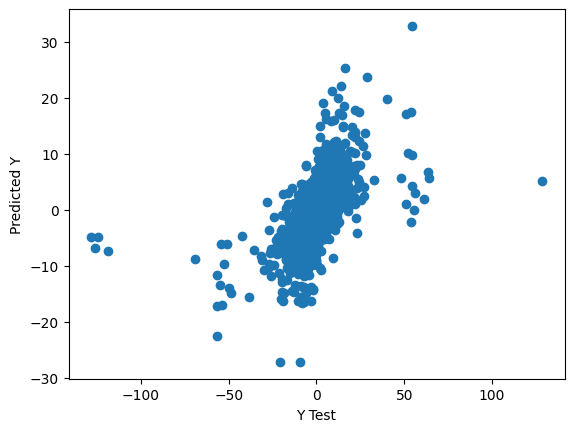

In [53]:
import matplotlib.pyplot as plt

plt.scatter(df_out['eval'],df_out['preds'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')